In [1]:
#!pip install numpy
#!pip install gym
#!pip install matplotlib
import numpy as np
import gym
import matplotlib.pyplot as plt
import pickle

In [2]:
#Spaces erstellen um stetige Werte für Position und Geschwindigkeit in diskrete Werte einzuordnen
pos_buckets = np.linspace(-1.2, 0.6, 20)
vel_buckets = np.linspace(-0.07, 0.07, 20)

In [3]:
#Status des Objektes wird in diskreten Werten zurückgegeben
def toDiscreteStates(obs):
    pos, vel = obs
    
    #stetige Werte von Position und Geschwindigkeit werden in den oben erstellten Spaces eingeordnet
    pos_disc = np.digitize(pos, pos_buckets)
    vel_disc = np.digitize(vel, vel_buckets)
    
    return(pos_disc, vel_disc)

In [4]:
#Funktion um die Aktion herauszufinden die wahrscheinlich die höchste Belohnung ergibt
def max_action(Q, obs, actions=[0,1,2]):
    state = toDiscreteStates(obs)
    values = []
    for a in actions:
        values.append(Q[state, a]) #Alle Werte der Bewertungsfunktion werden in einer Liste zusammengefasst
    
    action = np.argmax(values) #Maximaler Wert in der Bewertungsfunktion
    
    return action

In [5]:
env = gym.make('MountainCar-v0') #Umgebung generieren
env._max_episode_steps = 1000 #Maximale steps bis das Spiel abbricht, wenn es nicht geschafft wird
n_games = 50000
alpha = 0.1
gamma = 0.99
eps = 1.0

In [6]:
#2-Dimensionale Liste mit allen möglichen Status
states = [] 
for pos in range(21):
    for vel in range(21):
        states.append((pos,vel))

In [7]:
#Q-Tabelle als Dictionary der Form 441x3 mit allen Kombinationen aus Status und Aktionen
Q = {} 
for state in states:
    for action in [0,1,2]:
        Q[state, action] = 0

In [8]:
#Funktion um Q-Tabelle lokal abzuspeichern
def saveQ():
    with open('obj/Qtable.pkl', 'wb') as f:
        pickle.dump(Q, f, pickle.HIGHEST_PROTOCOL)

In [9]:
#Funktion um lokale Q-Tabelle zu laden und so an vorheriges lernen anknuepfen zu koennen
def loadQ():
    with open('obj/Qtable.pkl', 'rb') as f:
        return pickle.load(f)

In [10]:
#Die Q-Tabelle wird um neue Belohnungswerte aktualisiert
#Hier findet das eigentliche Lernen statt
def updateQ(obs, action, reward, new_obs, new_action):
    state = toDiscreteStates(obs)
    new_state = toDiscreteStates(new_obs)
    Q[state, action] = Q[state, action] + alpha*(reward + gamma*Q[new_state, new_action] - Q[state, action])

In [11]:
#Spielt mit der gespeicherten Q-Tabelle 10 Spiele um den Lernfortschritt darzustellen
def show_result():
    Q = loadQ() #lokal gespeicherte Q-Tabelle wird geladen
    new_eps = 0.01 #Epsilon wird direkt am Anfang auf den Minimalwert gesetzt da hier nicht dazu gelernt werden soll
    for i in range(10):
        done = False
        obs = env.reset()
        while not done:
            if np.random.random() < new_eps:
                action = np.random.choice([0,1,2])
            else:
                action = max_action(Q, obs)
        
            new_obs, reward, done, info = env.step(action)
            new_action = max_action(Q, new_obs)
            updateQ(obs, action, reward, new_obs, new_action)
            obs = new_obs
            env.render() #Spiel wird gerendert und dem Nutzer angezeigt

In [12]:
#In diesem Panel wird das eigentliche Spielen und Lernen ausgefuehrt

score = 0 #Belohnung eines einzelnen Spieldurchlaufes
total_rewards = np.zeros(n_games) #Belohnungen aller Durchlaeufe

#Q = loadQ()

for i in range(n_games):
    done = False
    obs = env.reset() #Beobachtung zum Startzeitpunkt
    if i % 100 == 0 and i>0:
        print('episode ', i, 'score ', score, 'eps ', eps)
    score = 0
    while not done:
        #Epsilon-Greedy-Algorithmus
        #Mit einer wahrscheinlichkeit von Epsilon wird eine zufällige Aktion ausgeführt
        if np.random.random() < eps:
            action = np.random.choice([0,1,2])
        #Sonst wird die Aktion ausgewählt die wahrscheinlich die beste Belohnung ergibt
        else:
            action = max_action(Q, obs)
        
        #Die oben ausgewaehlte Aktion wird ausgeführt
        #Die neue Beobachtung des Status, die Belohnung und die Information ob das Spiel vorbei ist werden zurueckgegeben
        new_obs, reward, done, info = env.step(action)
        score += reward
        new_action = max_action(Q, new_obs)
        updateQ(obs, action, reward, new_obs, new_action)
        obs = new_obs
    total_rewards[i] = score
    #Epsilon wird nach jedem Spiel so verringert, dass es nach der Haelfte der Zeit den Minimalwert erreicht
    if eps > 0.01:
        eps = eps - 2/n_games
    else:
        eps = 0.01

episode  100 score  -1000.0 eps  0.9970000000000026
episode  200 score  -1000.0 eps  0.9940000000000051
episode  300 score  -1000.0 eps  0.9910000000000077
episode  400 score  -1000.0 eps  0.9880000000000102
episode  500 score  -1000.0 eps  0.9850000000000128
episode  600 score  -1000.0 eps  0.9820000000000153
episode  700 score  -1000.0 eps  0.9790000000000179
episode  800 score  -1000.0 eps  0.9760000000000204
episode  900 score  -1000.0 eps  0.973000000000023
episode  1000 score  -1000.0 eps  0.9700000000000255
episode  1100 score  -1000.0 eps  0.9670000000000281
episode  1200 score  -1000.0 eps  0.9640000000000306
episode  1300 score  -1000.0 eps  0.9610000000000332
episode  1400 score  -1000.0 eps  0.9580000000000357
episode  1500 score  -1000.0 eps  0.9550000000000383
episode  1600 score  -1000.0 eps  0.9520000000000408
episode  1700 score  -1000.0 eps  0.9490000000000434
episode  1800 score  -1000.0 eps  0.9460000000000459
episode  1900 score  -1000.0 eps  0.9430000000000485
epi

episode  15700 score  -382.0 eps  0.5290000000004005
episode  15800 score  -465.0 eps  0.526000000000403
episode  15900 score  -304.0 eps  0.5230000000004056
episode  16000 score  -430.0 eps  0.5200000000004081
episode  16100 score  -601.0 eps  0.5170000000004107
episode  16200 score  -473.0 eps  0.5140000000004132
episode  16300 score  -351.0 eps  0.5110000000004158
episode  16400 score  -257.0 eps  0.5080000000004183
episode  16500 score  -249.0 eps  0.5050000000004209
episode  16600 score  -509.0 eps  0.5020000000004234
episode  16700 score  -569.0 eps  0.499000000000426
episode  16800 score  -283.0 eps  0.49600000000042854
episode  16900 score  -298.0 eps  0.4930000000004311
episode  17000 score  -306.0 eps  0.49000000000043364
episode  17100 score  -264.0 eps  0.4870000000004362
episode  17200 score  -273.0 eps  0.48400000000043875
episode  17300 score  -244.0 eps  0.4810000000004413
episode  17400 score  -248.0 eps  0.47800000000044385
episode  17500 score  -237.0 eps  0.47500000

episode  31100 score  -155.0 eps  0.067000000000624
episode  31200 score  -139.0 eps  0.06400000000062378
episode  31300 score  -128.0 eps  0.061000000000623555
episode  31400 score  -163.0 eps  0.05800000000062333
episode  31500 score  -176.0 eps  0.055000000000623106
episode  31600 score  -149.0 eps  0.05200000000062288
episode  31700 score  -223.0 eps  0.04900000000062266
episode  31800 score  -131.0 eps  0.04600000000062243
episode  31900 score  -147.0 eps  0.04300000000062221
episode  32000 score  -191.0 eps  0.04000000000062198
episode  32100 score  -147.0 eps  0.03700000000062176
episode  32200 score  -171.0 eps  0.03400000000062153
episode  32300 score  -176.0 eps  0.03100000000062134
episode  32400 score  -187.0 eps  0.028000000000621462
episode  32500 score  -156.0 eps  0.025000000000621584
episode  32600 score  -159.0 eps  0.022000000000621706
episode  32700 score  -141.0 eps  0.01900000000062183
episode  32800 score  -147.0 eps  0.01600000000062195
episode  32900 score  -15

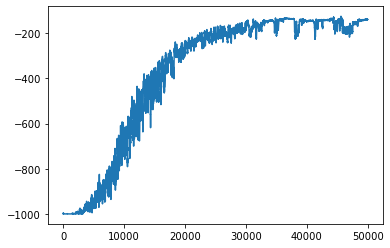

In [13]:
#saveQ()
#show_result()
mean_rewards = np.zeros(n_games)
for r in range(n_games):
    mean_rewards[r] = np.mean(total_rewards[max(0, r-50):(r+1)])
plt.plot(mean_rewards)
plt.savefig('mountaincar.png')